<a href="https://colab.research.google.com/github/WanjohiWanjohi/corona-measures/blob/master/Covid_measures_in_Senegal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An analysis on the effectiveness of measures implemented to curb the spread of COVID-19 in Senegal

Notebook Description
The following notebook contains an exploration of the trend infection rate in Senegal following measures implemented. The measures taken into account are :


1.   Ban on all religious gatherings on 2020/03/10
2.   Imposition of travel restrictions on 2020/03/15
3.   Declaration of a national state of emergency on 2020/03/23








In [3]:
## Installing the particular model created

!pip install git+https://github.com/Priesemann-Group/covid19_inference.git@v0.1.8

  Cloning https://github.com/Priesemann-Group/covid19_inference.git (to revision v0.1.8) to /tmp/pip-req-build-wtauei3r
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-wtauei3r
  Running command git checkout -b v0.1.8 --track origin/v0.1.8
  Switched to a new branch 'v0.1.8'
  Branch 'v0.1.8' set up to track remote branch 'v0.1.8' from 'origin'.
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=102471 sha256=bac84bd7f096bbc73f48656f7687c1c2d43379c08e93f2ab7a9628ec08861803
  Stored in directory: /tmp/pip-ephem-wheel-cache-0j_b6qj8/wheels/42/e7/e7/ee2035dd9edc0646359231afc5b2af9bf89c40c8256e0d6dba
Successfully built covid19-inference


# Task 2:
This task uses Bayesian inference technique to estimate the SIR model parameters, and apply Bayesian model comparison to select models that best fit the observed data

In [4]:
"""
    # Example for one region (bundesland)
    Non-hierarchical model using rki data.

    Runtime ~ 15 min

    The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.
"""
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

#we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19

"""## Data retrieval

    The next thing we want to do is load a dataset from somewhere.
    There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
    In this example we will use the RKI dataset.
"""
##get the data from the John Hopkins Dataset
jhu = cov19.data_retrieval.JHU(auto_download=True)
jhu.download_all_available_data()
dfeth = jhu.confirmed.Senegal
#dfeth[dfeth["NaN"] > 100]
dfeth.columns = ['cases']
#preprocess the data from when cases are at 100
dff = dfeth[dfeth["cases"] > 100]
dff


INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.
INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


,cases
2020-03-26,105
2020-03-27,119
2020-03-28,130
2020-03-29,142
2020-03-30,162
...,...
2020-08-03,10386
2020-08-04,10432
2020-08-05,10538
2020-08-06,10715


In [8]:
bd = datetime.datetime(2020, 3, 22)  # For the date filter
ed = datetime.datetime.now()
total_cases_obs_train = jhu.get_total(
    value="confirmed", country='Senegal', data_begin=bd, data_end=ed
)
new_cases_obs_train = jhu.get_new(
    value="confirmed", country='Senegal', data_begin=bd, data_end=ed
)
new_cases_obs_train[new_cases_obs_train.isnull()]

Series([], Name: confirmed, dtype: int64)

In [9]:
#split the data into training and testing set
training_set  = dff[dff.index < '2020-07-25']
testing_set = dff[dff.index >= '2020-07-25']


# Create the Model

In [10]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 10)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)

change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

# Initialize Model Parameters
 There are default values for most of the function arguments,
    but we will try to explicitly set all kwargs![alt text](https://)

In [11]:
params_model = dict(
    new_cases_obs=new_cases_obs_train[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10


#Specifying a model context

In [12]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

# MCMC sampling

In [13]:
"""
    After the model is built, it is sampled using an MCMC sampler.
    The number of parallel runs can be set with the argument `cores=`.
    In particular, due to a bug in Theano, Windows users should set `cores=1`.
    The sampling can take a long time.
"""

trace = pm.sample(model=this_model, tune=50, draws=100, cores=3, init="advi+adapt_diag")
trace


Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 840.04:  13%

<MultiTrace: 3 chains, 100 iterations, 36 variables>

# Plots

['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


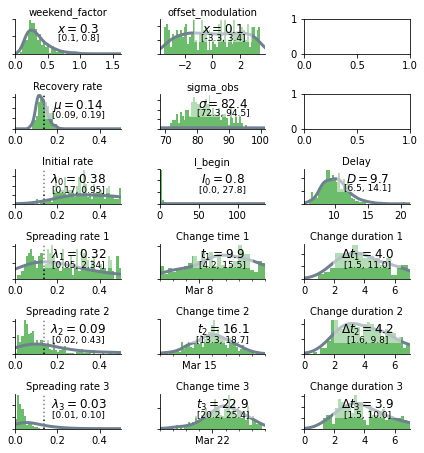

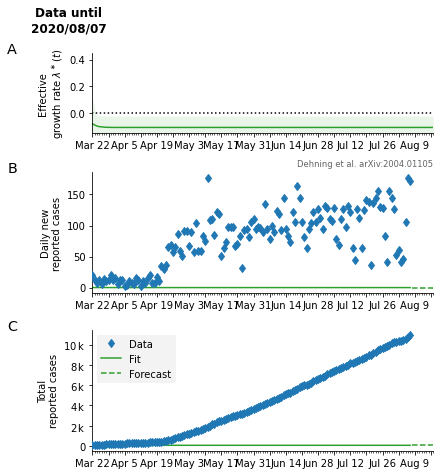

In [15]:
### Distributions

fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

# Plot them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

fig.tight_layout()
fig  # To print in jupyter notebook

"""### Timeseries
    timeseries overview, for now needs an offset variable to get cumulative cases
"""
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=total_cases_obs_train[0])
